# Import necessary libraries

In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests 
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# Open and prepare the files

To find the differential expressed genes we need the scaled data, and the file cluster_labs, where its indicated which cluster each sample belongs to.

In [2]:
file_path_d = '/Volumes/TOSHIBA/4t/Advanced Bioinformatics/Project/Python/scaled_data.csv'
file_path_c = '/Volumes/TOSHIBA/4t/Advanced Bioinformatics/Project/Python/cluster_labs.csv'

df = pd.read_csv(file_path_d, index_col = 0)
clust = pd.read_csv(file_path_c, index_col = 0)

In [3]:
df

,77322072-2a7f-49e6-a9d1-c521c25acd70.rna_seq.augmented_star_gene_counts.tsv,6f6bf240-1ca4-47d0-9a77-17b0ce9b8ae7.rna_seq.augmented_star_gene_counts.tsv,59e8b7b7-5183-4655-aa5e-e4b5ba73eded.rna_seq.augmented_star_gene_counts.tsv,5418228b-cfd0-4580-87c6-3ebf6282ad73.rna_seq.augmented_star_gene_counts.tsv,c7fd0bf8-753e-45d6-b987-51ec7559f728.rna_seq.augmented_star_gene_counts.tsv,50c308c9-922a-4083-ae09-e5e4d8c437af.rna_seq.augmented_star_gene_counts.tsv,55071ef3-bf09-43a2-a54c-a9ec61a84615.rna_seq.augmented_star_gene_counts.tsv,7d9c7c34-76e0-4622-b5f7-60e12f6d4e07.rna_seq.augmented_star_gene_counts.tsv,32675d71-6f79-4b8f-ab7c-e2350b15875c.rna_seq.augmented_star_gene_counts.tsv,3d11905a-16eb-40b2-a36b-e37dca6359d3.rna_seq.augmented_star_gene_counts.tsv,...,4c87674d-dd05-490d-a584-84490509f4d4.rna_seq.augmented_star_gene_counts.tsv,5cfb768f-7b49-4a72-92c9-d7502f5ba5b8.rna_seq.augmented_star_gene_counts.tsv,03ef99c7-55b7-4770-9eac-2ee007aa78ca.rna_seq.augmented_star_gene_counts.tsv,3ab1dfbc-ab83-446e-b680-cd6aec12b177.rna_seq.augmented_star_gene_counts.tsv,029a2c3e-0fd1-4cb4-9021-3947d28ca28d.rna_seq.augmented_star_gene_counts.tsv,ed41fe8b-fe2e-4bf3-91e3-2cf50ddcbc78.rna_seq.augmented_star_gene_counts.tsv,b9a5766c-e155-423e-a075-10fb14fe87df.rna_seq.augmented_star_gene_counts.tsv,a462c0f9-23d3-428b-9b61-e42cb6a68af1.rna_seq.augmented_star_gene_counts.tsv,0d3cfbc0-4420-48ed-a459-2e18d2ece5b6.rna_seq.augmented_star_gene_counts.tsv,d43517e2-e447-42cc-93e1-cbc9669ef4f1.rna_seq.augmented_star_gene_counts.tsv
ENSG00000001626.16,-0.918857,0.354463,0.669931,-0.004913,0.932431,-1.014828,0.342254,-1.267665,-0.679622,0.651353,...,-0.514954,-1.254341,-1.035943,-0.638302,0.535542,-1.064393,0.360062,0.287321,0.199326,-1.017340
ENSG00000002587.10,0.667931,0.588161,0.972102,-0.121360,-0.260335,0.348153,0.404158,1.138810,0.979133,0.305681,...,0.545757,-0.441574,-0.622337,0.089450,0.154821,0.389915,1.033114,0.886676,0.273785,-0.030065
ENSG00000002726.21,2.344571,2.413099,-0.918564,1.056183,0.064067,-0.644641,-0.508981,2.335432,1.714089,-1.082838,...,-0.691096,-0.922039,-0.788419,-1.115137,-0.041051,-0.709321,-0.605173,-1.089038,0.950182,-0.702366
ENSG00000003249.15,1.666661,0.928660,0.476471,1.475588,0.453396,2.199378,1.563587,1.438787,1.082130,-0.835569,...,0.267487,0.379203,0.287600,0.556970,0.306918,0.194378,0.100283,0.500589,0.636376,0.219987
ENSG00000003989.18,0.653280,0.445212,0.991912,-0.662140,1.271346,-0.596174,2.100424,1.320881,0.653506,0.811123,...,-0.323125,0.295977,0.728450,0.110973,0.362201,0.122449,0.419678,-0.333982,0.789467,-0.601821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000287269.1,-1.304426,-1.462015,-1.148756,-1.273838,-1.219620,-1.090739,-0.863526,-1.194802,-1.730803,0.801995,...,-0.554897,-0.723096,-1.150592,-0.635894,-0.967600,0.014044,-1.148157,-0.404309,-0.869177,-0.748484
ENSG00000287458.1,-1.457492,-1.559597,-1.562592,-1.273838,-0.939429,-1.571997,-1.305608,-1.549453,-1.053264,1.958032,...,-1.250882,-0.925081,-1.308395,-1.137278,-1.500804,-1.250231,-1.517153,-1.382394,-1.166416,-1.379215
ENSG00000287580.1,-0.775674,-0.539202,0.003417,-0.252665,-1.062103,-0.210105,-0.608011,-0.662296,-0.753401,0.864476,...,-0.498855,-0.214131,-0.793708,-0.946301,-0.998324,-0.892083,-1.517153,0.073237,-0.353244,-0.250733
ENSG00000288662.1,-1.801745,-1.723959,-1.562592,-1.273838,-0.504325,-1.571997,-1.600299,-0.735243,-1.730803,-1.118876,...,-1.250882,-1.361193,-1.486195,-1.455945,-1.500804,-1.428118,-1.517153,-1.382394,-1.358715,-1.379215


Now, we are going to create a dictionary where the keys are the different clusters (1, 2, 3, 4) and values are names of samples.

In [4]:
clust_dic = {cluster: clust.index[clust['x'] == cluster].tolist() for cluster in range(1, 5)}

# Find DEGs of each group of samples

First we are going to create the function that we are going to apply on out data do find
DEGs:
For each cluster (each key in the dictionary clust_dic), we pick all the samples and we also define other clusters samples; so we can perform t-test for each gene of the data between the current cluster and the rest and calculate its FC.
Then, for the obtained results, we will adjust the p - values using FDR correction (alpha = 0.05). Finally, we will categorize genes based on adjusted p-values and fold changes in three groups: normal, up, and down.

In [5]:
def find_cluster_specific_degs(clustered_samples, dataframe, t_fc = 1.0):
    path = '/Volumes/TOSHIBA/4t/Advanced Bioinformatics/Project/Python/'
    cluster_results = defaultdict(dict)
    cluster_results = defaultdict(lambda: {
        "genes": [],
        "p_values": [],
        "fold_changes": [],
        "q-values": [],
        "DEGs": []
    })

    for cluster in clustered_samples:
        cluster_samples = clustered_samples[cluster]
        other_samples = [sample for other_cluster in clustered_samples if other_cluster != cluster
                         for sample in clustered_samples[other_cluster]]

        for gene in dataframe.index:
            cluster_expression = dataframe.loc[gene, cluster_samples]
            other_expression = dataframe.loc[gene, other_samples]

            fold_change = np.mean(cluster_expression) - np.mean(other_expression)
            t_stat, p_value = ttest_ind(cluster_expression, other_expression)

            cluster_results[cluster]["genes"].append(gene)
            cluster_results[cluster]["p_values"].append(p_value)
            cluster_results[cluster]["fold_changes"].append(fold_change)

    for cluster, data in cluster_results.items():
        _, adjusted_p_values, _, _ = multipletests(data["p_values"], alpha = 0.05, method='fdr_bh')
        adjusted_p_values = np.clip(adjusted_p_values, np.min(np.nonzero(adjusted_p_values)) + 1e-320, None)
        data["q-values"] = adjusted_p_values
        data["DEGs"] = []

        for p_val, fc in zip(data["q-values"], data["fold_changes"]):
            if p_val <= 0.05 and abs(fc) >= t_fc:
                data["DEGs"].append("UP" if fc > 0 else "DOWN")
            else:
                data["DEGs"].append("NORMAL")

        result_df = pd.DataFrame({
            "Gene": data["genes"],
            "P-Value": data["p_values"],
            "q-value": data["q-values"],
            "Fold Change": data["fold_changes"],
            "DEGs": data["DEGs"]
        })
        file_path = os.path.join(path, f'cluster_{cluster}_degs.csv')
        result_df.to_csv(file_path, index=False)
    return cluster_results

Now, we can apply the created function to find each cluster-specific DEGs; and see how many upregulated and downregulated genes we have in each group. If we then visualize top 5 DEGs of each cluster, we can see that all obtained p - values are so close to 0 (but probably not 0). That's because our clusters of samples are well defined and really different from each other.

In [6]:
cluster_specific_degs = find_cluster_specific_degs(clust_dic, df)

In [7]:
for cluster, data in cluster_specific_degs.items():

    sorted_indices = sorted(range(len(data["fold_changes"])), key=lambda k: data["fold_changes"][k], reverse=True)
    top_5_indices = sorted_indices[:5]
    top_5_genes = [data["genes"][idx] for idx in top_5_indices]
    top_5_pvalues = [data["q-values"][idx] for idx in top_5_indices]
    top_5_fc = [data["fold_changes"][idx] for idx in top_5_indices]
    
    print(f"Cluster {cluster} DEGs:")
    print(f"Number of upregulated genes: {sum([1 for deg in data['DEGs'] if deg == 'UP'])}")
    print(f"Number of downregulated genes: {sum([1 for deg in data['DEGs'] if deg == 'DOWN'])}")
    print("\n")

    print(f"Top 5 upregulated DEGs for Cluster {cluster}:")
    for gene, q_value, fc in zip(top_5_genes, top_5_pvalues, top_5_fc):
        print(f"Gene: {gene}, q - value: {q_value:.4f}, Log2(FC): {fc:.4f}")
    print("\n")


Cluster 1 DEGs:
Number of upregulated genes: 114
Number of downregulated genes: 362


Top 5 upregulated DEGs for Cluster 1:
Gene: ENSG00000225630.1, q - value: 0.0000, Log2(FC): 2.1279
Gene: ENSG00000196260.5, q - value: 0.0000, Log2(FC): 1.9244
Gene: ENSG00000165215.6, q - value: 0.0000, Log2(FC): 1.7782
Gene: ENSG00000102854.16, q - value: 0.0000, Log2(FC): 1.5892
Gene: ENSG00000164266.11, q - value: 0.0000, Log2(FC): 1.5861


Cluster 2 DEGs:
Number of upregulated genes: 383
Number of downregulated genes: 92


Top 5 upregulated DEGs for Cluster 2:
Gene: ENSG00000266019.1, q - value: 0.0000, Log2(FC): 4.1688
Gene: ENSG00000202538.1, q - value: 0.0000, Log2(FC): 4.0760
Gene: ENSG00000252010.1, q - value: 0.0000, Log2(FC): 4.0665
Gene: ENSG00000238741.1, q - value: 0.0000, Log2(FC): 3.8072
Gene: ENSG00000252835.1, q - value: 0.0000, Log2(FC): 3.7322


Cluster 3 DEGs:
Number of upregulated genes: 277
Number of downregulated genes: 320


Top 5 upregulated DEGs for Cluster 3:
Gene: ENSG000

# Visualizing the results: Volcano plots

To visualize DEGs, we are going to do a volcano plot for each comparison (so 4 plots, of each cluster genes expression compared to all others).

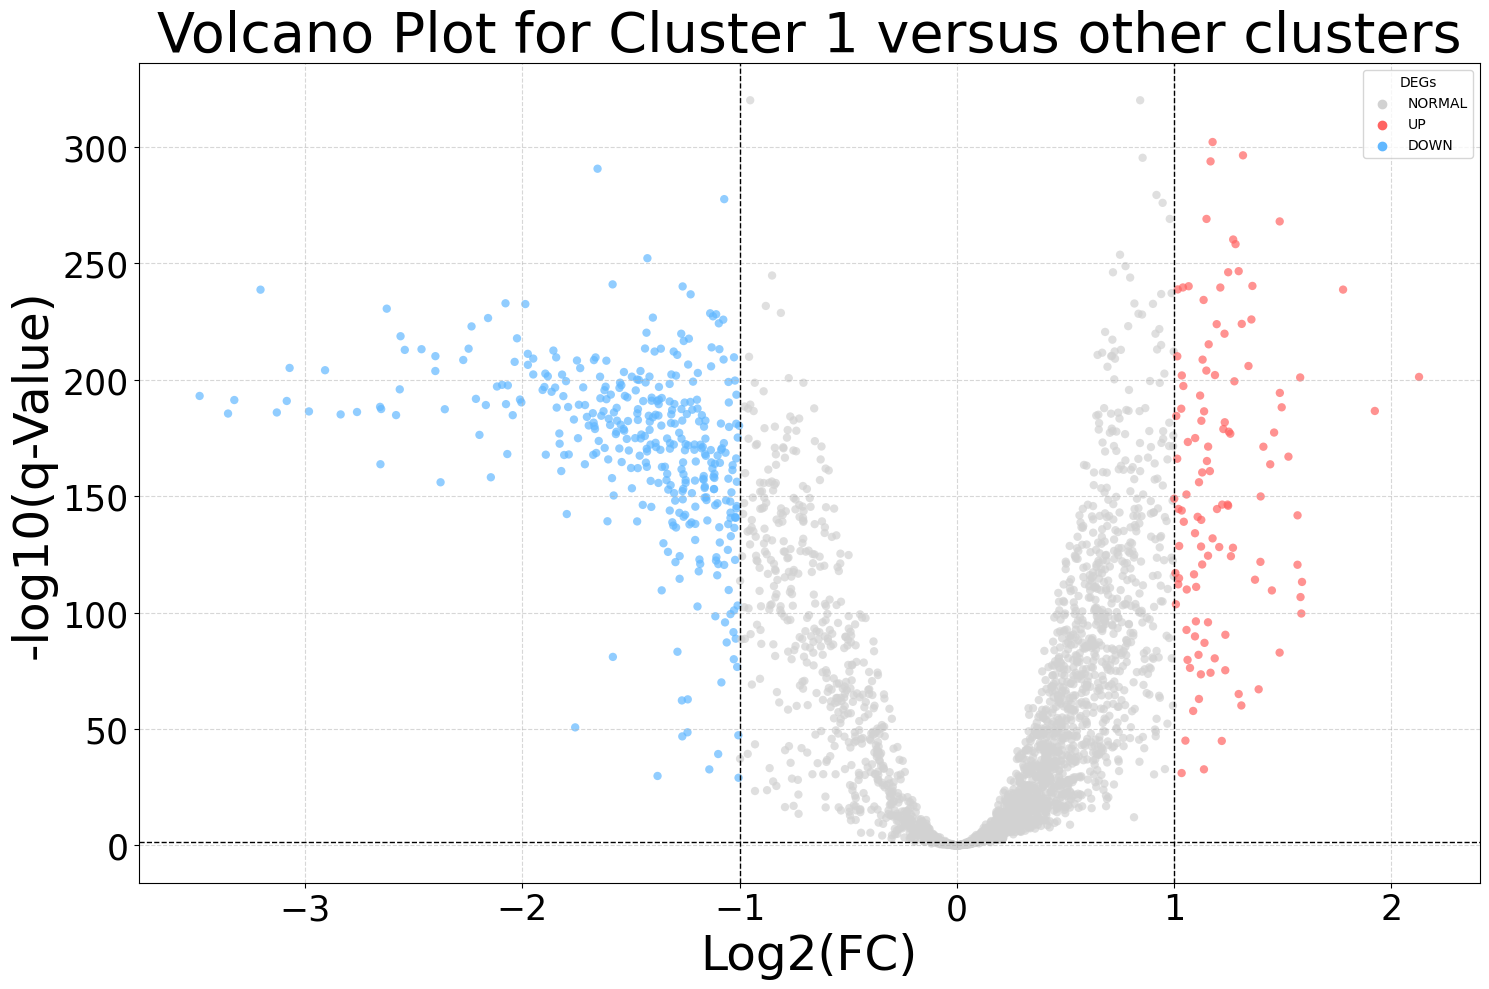

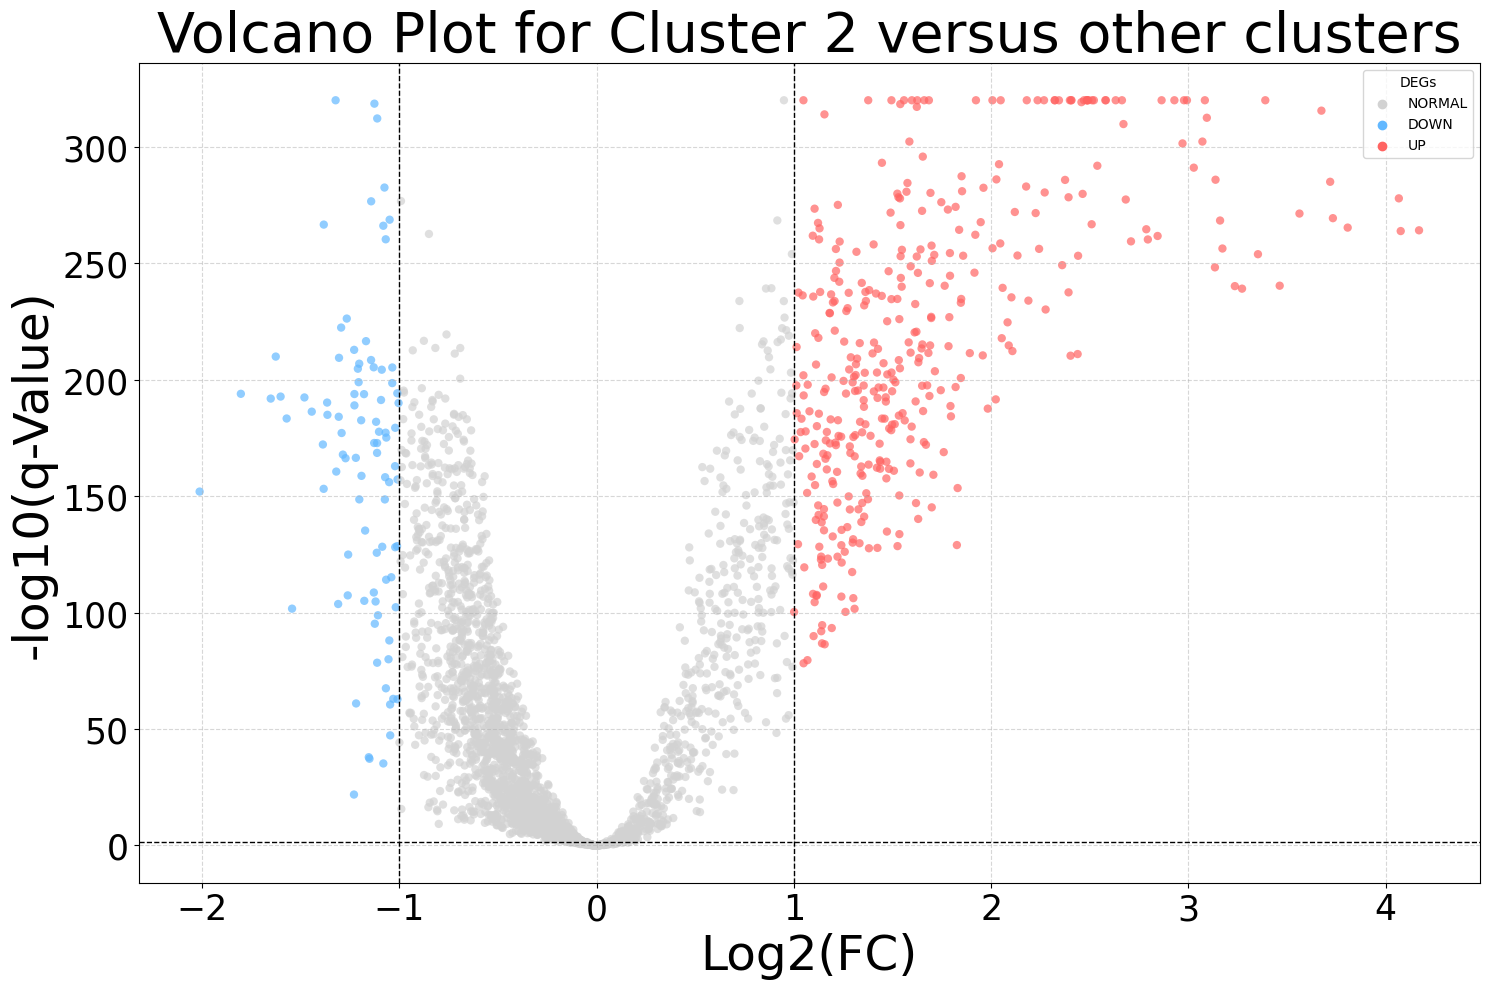

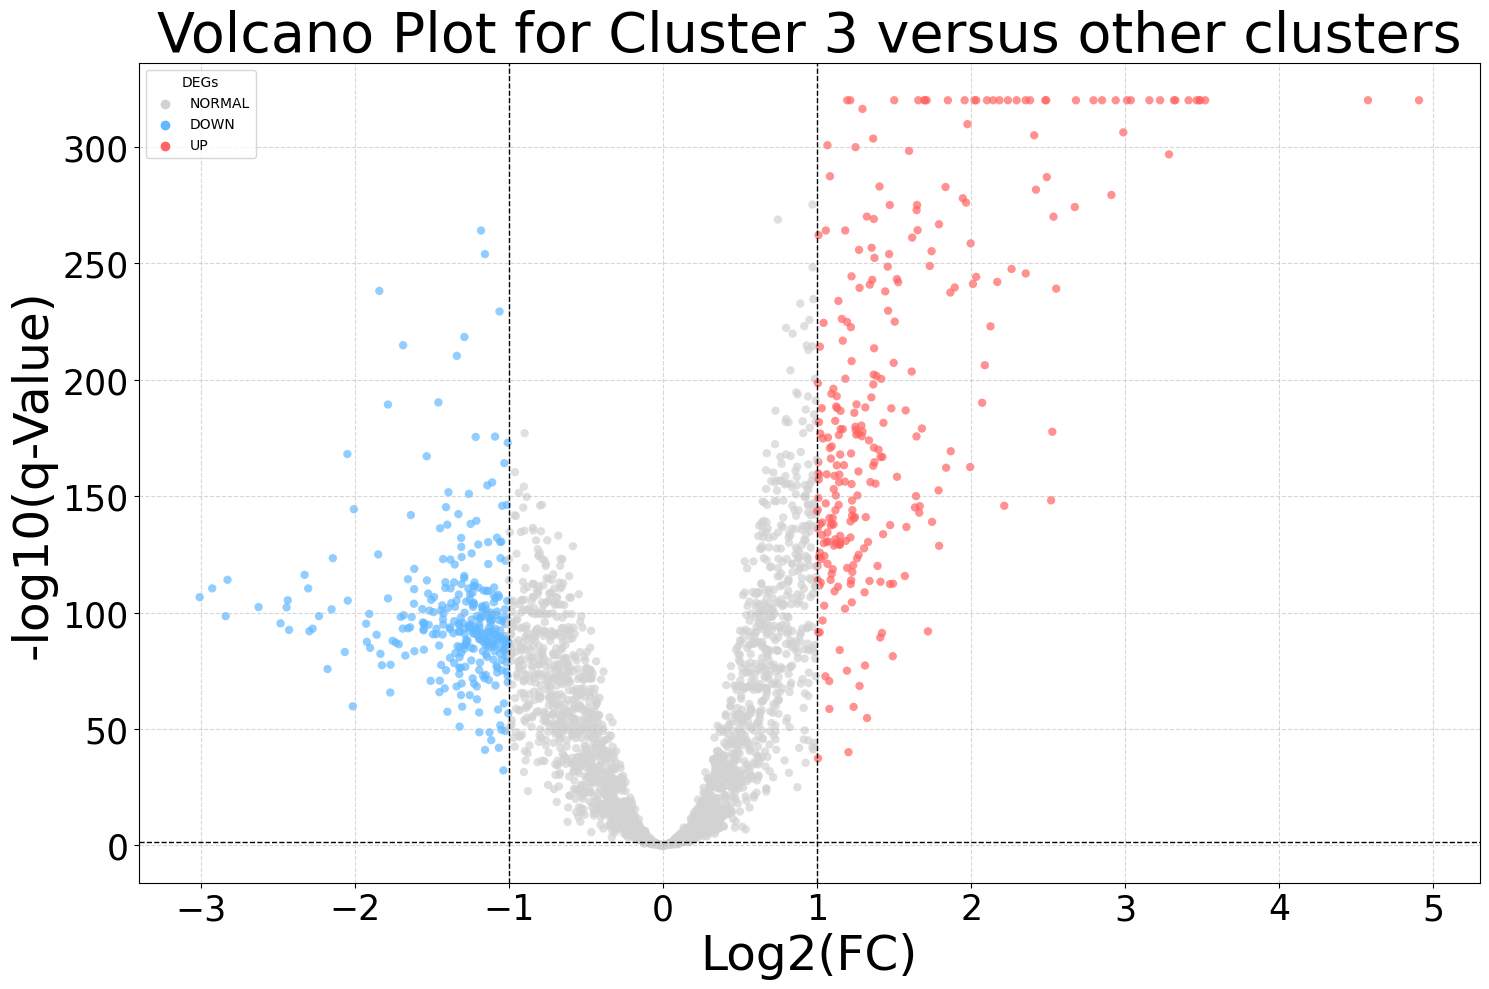

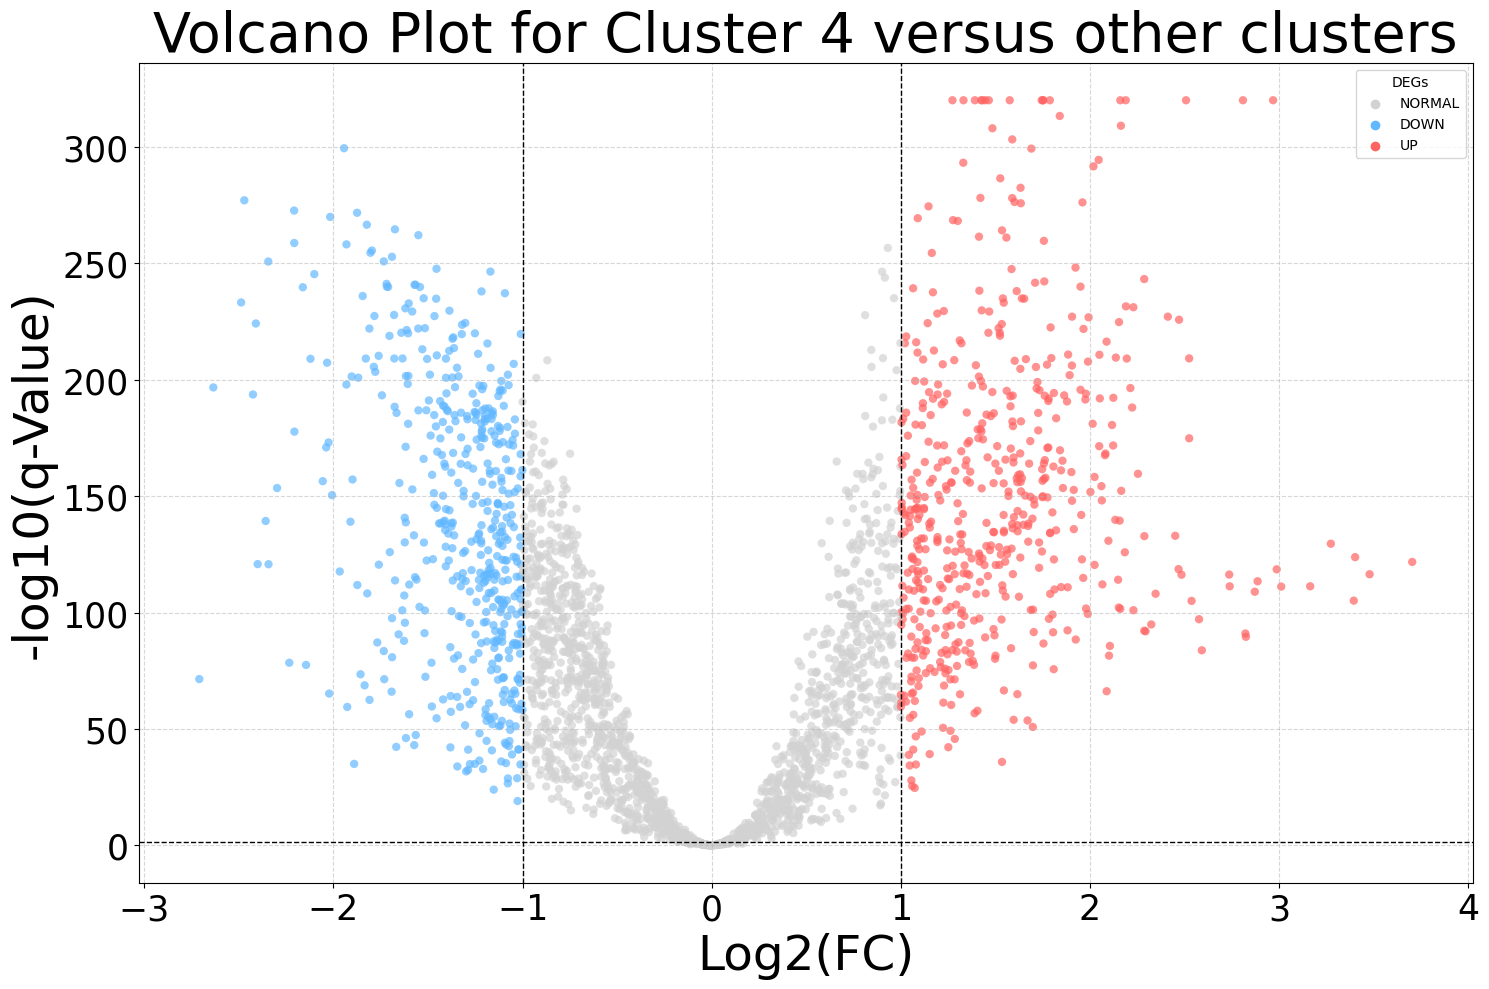

In [9]:
colors = {"NORMAL":"#D2D2D2", "UP":"#FF6462", "DOWN":"#62B8FF"} 

for cluster, data in cluster_specific_degs.items():
    cluster_df = pd.DataFrame({
        "Gene": data["genes"],
        "q-value": data["q-values"],
        "Fold Change": data["fold_changes"],
        "DEGs": data["DEGs"]
    })      
    
    plt.figure(figsize = (15, 10))
    sns.scatterplot(x = cluster_df["Fold Change"], y = -np.log10(cluster_df["q-value"]),
                    hue = cluster_df["DEGs"], palette = colors, edgecolor = "none", alpha = 0.7)
    
    plt.axhline(-np.log10(0.05), color="k", linestyle="--", linewidth=1)
    plt.axvline(1, color="k", linestyle="--", linewidth=1)
    plt.axvline(-1, color="k", linestyle="--", linewidth=1)

    plt.xlabel("Log2(FC)", fontsize = 35)
    plt.ylabel("-log10(q-Value)", fontsize = 35)
    plt.title(f"Volcano Plot for Cluster {cluster} versus other clusters", fontsize = 40)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"/Volumes/TOSHIBA/4t/Advanced Bioinformatics/Project/Python/Graphs/"+"volcano_plot_cluster_{cluster}.svg")